#Data Preperation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Label mapping
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Data directory and CSV path
csv_path = "/content/drive/MyDrive/xrd_training/structure_info.csv"  # Replace with actual path
!unzip /content/drive/MyDrive/xrd_training/output_data.zip -d /content/drive/MyDrive/xrd_training
data_dir = "/content/drive/MyDrive/xrd_training/output_data"  # Directory with .npz files
df = pd.read_csv(csv_path)

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/drive/MyDrive/xrd_training/output_data/4000950_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/2010029_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/9005109_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/9001581_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/7204651_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/9015097_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/9017878_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/2002958_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/4336921_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/4344119_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_training/output_data/2106754_convolved.npz  
  inflating: /content/drive/MyDrive/xrd_trai

In [6]:
# Preprocessing function
def load_xrd_data(file_list, data_dir):
    X, y = [], []
    for file_name, label in file_list:
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)

        # Load intensity data
        if os.path.exists(file_path):
            data = np.load(file_path)
            x = data['y_convolved'].astype(np.float32)  # Use intensity data
            X.append(x)
            y.append(label_map[label])
    return np.array(X), np.array(y)

# Split the data into train, test, and validation sets
split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3000, 500, 300),
    "trigonal": (1500, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (1800, 500, 100),
    "monoclinic": (3000, 500, 300),
    "hexagonal": (100, 10, 5)
}

In [7]:
train_list, test_list, val_list = [], [], []

for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split into training, testing, and validation sets
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, _ = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

In [8]:
# Load the datasets
X_train, y_train = load_xrd_data(train_list, data_dir)
X_test, y_test = load_xrd_data(test_list, data_dir)
X_val, y_val = load_xrd_data(val_list, data_dir)

# Flatten the feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)


In [9]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Label map for the classification task
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Function to extract features from XRD data
def extract_features_with_all_peaks(intensity, angles, max_peaks=10):
    # Find all peaks
    peaks, _ = find_peaks(intensity, height=0.05 * np.max(intensity))  # Adjust height threshold
    peak_positions = angles[peaks]  # Positions of detected peaks (2θ values)
    peak_intensities = intensity[peaks]  # Intensities of detected peaks

    # Total number of detected peaks
    num_detected_peaks = len(peaks)

    # If fewer peaks are detected than the maximum allowed, pad with zeros
    if num_detected_peaks < max_peaks:
        peak_positions = np.pad(peak_positions, (0, max_peaks - num_detected_peaks), mode='constant')
        peak_intensities = np.pad(peak_intensities, (0, max_peaks - num_detected_peaks), mode='constant')
        widths = np.zeros(max_peaks)
    else:
        # Compute Full Width at Half Maximum (FWHM) of each peak
        widths = peak_widths(intensity, peaks)[0]  # widths of the peaks

    # Compute global statistics
    avg_peak_intensity = np.mean(peak_intensities) if num_detected_peaks > 0 else 0
    std_peak_intensity = np.std(peak_intensities) if num_detected_peaks > 0 else 0
    mean_fwhm = np.mean(widths) if num_detected_peaks > 0 else 0
    std_fwhm = np.std(widths) if num_detected_peaks > 0 else 0

    # Create feature vector with peak positions, intensities, and FWHM, followed by global statistics
    feature_vector = np.concatenate([
        peak_positions[:max_peaks],  # First 10 peaks' positions
        peak_intensities[:max_peaks],  # First 10 peaks' intensities
        #widths[:max_peaks],  # First 10 peaks' FWHM values
        #[num_detected_peaks, avg_peak_intensity, std_peak_intensity]
        [num_detected_peaks]
    ])

    return feature_vector

def process_data_with_all_peaks(file_list, data_dir, max_peaks=10):
    features = []
    labels = []
    for file_name, label in file_list:
        # Replace .cif with .npz
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)
        data = np.load(file_path)
        intensity = data['y_convolved'].astype(np.float32)
        angles = data['x_fine'].astype(np.float32)

        # Extract features with all peaks and statistics
        feature = extract_features_with_all_peaks(intensity, angles, max_peaks)
        features.append(feature)
        labels.append(label_map[label])

    return np.array(features), np.array(labels)


In [11]:
train_list, test_list, val_list = [], [], []
for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split the dataset
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, temp_files = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

In [12]:
# Define maximum number of peaks for padding
max_peaks = 10

# Process datasets to extract features and labels
X_train, y_train = process_data_with_all_peaks(train_list, data_dir, max_peaks)
X_test, y_test = process_data_with_all_peaks(test_list, data_dir, max_peaks)
X_val, y_val = process_data_with_all_peaks(val_list, data_dir, max_peaks)


In [13]:
print(X_train[0])

[17.36145401 23.96223068 24.65231133 27.63266182 29.74291039 33.10330582
 35.14354706 38.30391693 41.71432114 42.98447037  0.05396441  1.03090763
  0.68766594  0.05283605  0.26896563  0.39668053  0.68429852  0.05672311
  0.21172881  0.58514643 31.        ]


In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

class XRDDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)  # Convert features to Tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to Tensor

    def __len__(self):
        return len(self.features)  # Number of samples

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]  # Return feature and label at index `idx`


In [15]:
# 建立 Dataset 實例
train_dataset = XRDDataSet(X_train, y_train)
test_dataset = XRDDataSet(X_test, y_test)
val_dataset = XRDDataSet(X_val, y_val)

# 建立 DataLoader
batch_size = 64  # 定義 batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


#CNN_BiLSTM

In [16]:
import torch
import torch.nn as nn

class CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_BiLSTM, self).__init__()
        # 1D CNN Layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout_cnn = nn.Dropout(0.3)

        # BiLSTM Layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 2, 128)  # 64 * 2: BiLSTM 輸出雙向拼接
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout_fc = nn.Dropout(0.3)

    def forward(self, x):
        # CNN Layers
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout_cnn(x)

        # LSTM expects input of shape [batch, seq_len, feature]
        x = x.permute(0, 2, 1)  # [batch, channels, seq_len] -> [batch, seq_len, channels]

        # BiLSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最後一個時間步的輸出 (也可嘗試全局平均池化)

        # Fully Connected Layers
        x = torch.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


##Training

In [17]:
import torch.nn.functional as F

def evaluate_epoch(model, data_loader, criterion):
    """
    評估模型在數據集上的表現，計算平均損失和準確率。

    Args:
    - model (nn.Module): 待評估的 PyTorch 模型。
    - data_loader (DataLoader): 驗證或測試集的數據加載器。
    - criterion (nn.Module): 損失函數。

    Returns:
    - avg_loss (float): 在數據集上的平均損失。
    - accuracy (float): 分類準確率 (0-1 範圍)。
    """
    model.eval()  # 設置模型為評估模式
    device = next(model.parameters()).device  # 獲取模型的設備
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 關閉梯度計算以加速評估
        for inputs, labels in data_loader:
            # 將數據移動到設備（GPU 或 CPU）
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape to (batch_size, 1, num_features) to match model input
            inputs = inputs.reshape(inputs.shape[0], 1, -1)

            # 前向傳播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 記錄損失
            total_loss += loss.item()

            # 計算準確率
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # 平均損失
    avg_loss = total_loss / len(data_loader)

    # 準確率
    accuracy = correct / total

    return avg_loss, accuracy

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=probs.size(1)).float()

        pt = torch.sum(targets_one_hot * probs, dim=1)
        log_pt = torch.log(pt)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = -alpha_t * (1 - pt) ** self.gamma * log_pt
        else:
            loss = -(1 - pt) ** self.gamma * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

**Note: Pick Loss Function Here**

In [18]:
# 定義類別數量（如晶系數量）
num_classes = 7

# 初始化模型
model = CNN_BiLSTM(num_classes=num_classes).to(device)
print(model)


# Pick your loss function: CrossEntropy or FocalLoss here
criterion = nn.CrossEntropyLoss()
# criterion = FocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_list = []
val_acc_list = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# 訓練範例
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    loss_list.clear()
    val_acc_list.clear()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        iterator = 1

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Reshape to (batch_size, 1, num_features)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iterator += 1
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_list.append(running_loss)
        val_loss,val_acc = evaluate_epoch(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Acc on Val: {val_acc:.4f}")


CNN_BiLSTM(
  (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout_cnn): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
  (dropout_fc): Dropout(p=0.3, inplace=False)
)


In [19]:
epochs = 100
# 開始訓練
train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)

Epoch 1/1, Loss: 1.4718
Epoch 1/1, Acc on Val: 0.3891


In [ ]:
torch.save(model, "/content/drive/MyDrive/xrd_training/CNNLSTM_epoch100_peakdata.pt")

In [20]:
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(loss_list, val_acc, num_epochs):
    """
    繪製訓練損失和驗證準確率在同一張圖上。

    Args:
    - loss_list (list): 訓練損失值列表。
    - val_acc (list): 驗證準確率值列表。
    - num_epochs (int): 總訓練 epoch 數。
    """
    epochs = range(1, num_epochs + 1)  # x 軸的 epoch 列表

    # 創建圖表
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # 左軸：訓練損失
    ax1.plot(epochs, loss_list, 'b-', label='Train Loss')  # 藍色線條
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')  # Y 軸使用藍色標籤

    # 右軸：驗證準確率
    ax2 = ax1.twinx()  # 創建共享 x 軸的新 y 軸
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')  # 紅色線條
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')  # Y 軸使用紅色標籤

    # 加入圖例
    fig.tight_layout()  # 自動調整布局
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 顯示圖表
    plt.title('Training Loss and Validation Accuracy')
    plt.show()

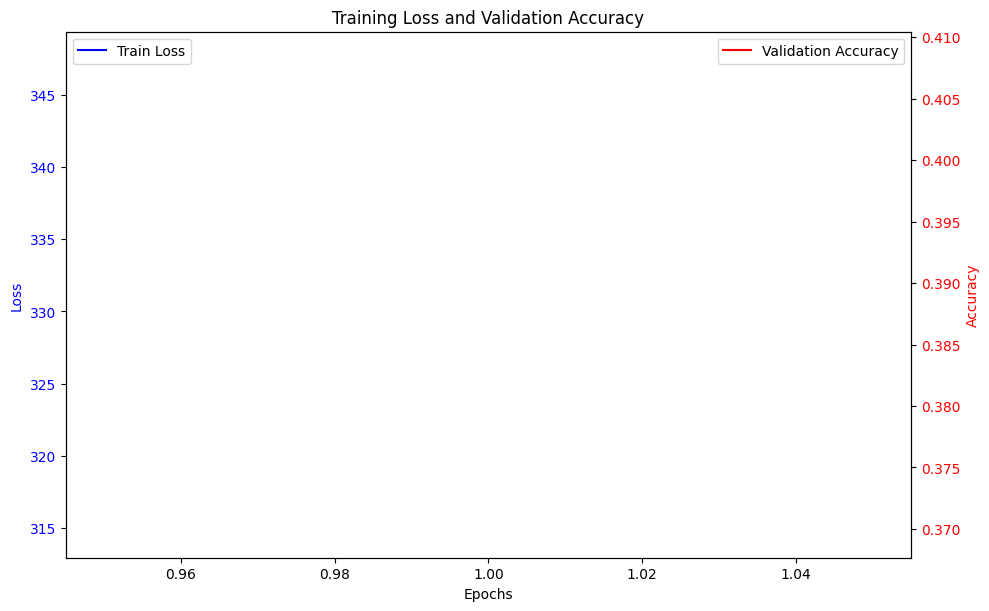

In [21]:
plot_loss_and_accuracy(loss_list, val_acc_list, epochs)

##Evaluation

In [22]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

In [23]:
evaluate_model(model, test_loader)

Accuracy: 36.05%


36.04651162790697

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

def evaluate_and_plot_confusion_matrix(model, data_loader, label_map, sample_percentage=0.5, seed=42):
    """
    Evaluates the model on a random sample of the data and plots a confusion matrix with percentage accuracies.

    Parameters:
    - model: The PyTorch model to evaluate.
    - data_loader: A DataLoader providing input data and labels.
    - label_map: A dictionary mapping class names to indices.
    - sample_percentage: The percentage of data to sample randomly for evaluation (default 50%).
    - seed: Random seed for reproducibility (default 42).

    Returns:
    - confusion_matrix_percent: A confusion matrix with percentage accuracies.
    """
    # Ensure GPU usage if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    # Initialize confusion matrix
    num_classes = len(label_map)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    # Set random seed for reproducibility
    random.seed(seed)

    # Select a random subset of the data_loader (sample_percentage)
    total_samples = len(data_loader.dataset)
    num_samples_to_select = int(total_samples * sample_percentage)
    indices = random.sample(range(total_samples), num_samples_to_select)

    # Create a new DataLoader with the sampled indices
    sampled_data = torch.utils.data.Subset(data_loader.dataset, indices)
    sampled_loader = torch.utils.data.DataLoader(sampled_data, batch_size=data_loader.batch_size, shuffle=False)

    # Evaluate the model on the sampled data
    with torch.no_grad():
        for inputs, labels in sampled_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)

            # Perform forward pass
            outputs = model(inputs)  # Outputs shape: [batch_size, num_classes]
            _, predicted = torch.max(outputs, 1)

            # Update confusion matrix
            for label, pred in zip(labels, predicted):
                confusion_matrix[label.item(), pred.item()] += 1

    # Calculate percentage accuracies for each row (true class)
    confusion_matrix_percent = np.zeros_like(confusion_matrix, dtype=np.float32)

    for i in range(num_classes):
        total = confusion_matrix[i].sum()
        if total > 0:
            confusion_matrix_percent[i] = 100 * confusion_matrix[i] / total

    # Plot the confusion matrix as a heatmap
    class_names = list(label_map.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names, cbar=True)
    plt.title("Confusion Matrix (Percentage Accuracy)", fontsize=16)
    plt.xlabel("Predicted Class", fontsize=14)
    plt.ylabel("True Class", fontsize=14)
    plt.show()

    return confusion_matrix_percent


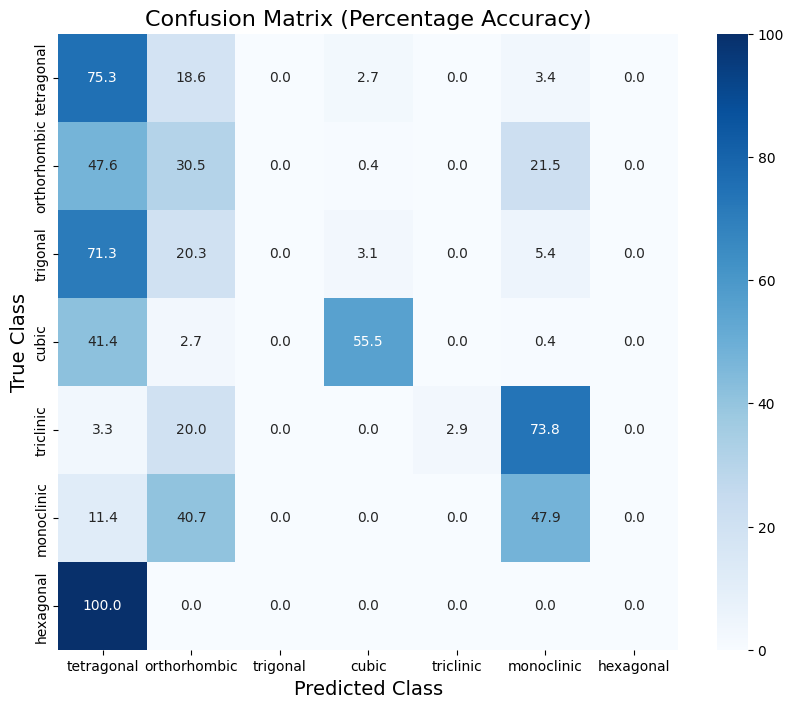

In [25]:
confusion_matrix_percent = evaluate_and_plot_confusion_matrix(model, test_loader, label_map)

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

def extract_features_from_model(model, dataloader, device):
    model.eval()  # 設定為推論模式
    all_features = []
    all_labels = []

    with torch.no_grad():  # 停止梯度計算
        for inputs, labels in dataloader:
            # 確保數據與設備匹配
            inputs = inputs.reshape(inputs.shape[0], 1, -1)
            inputs, labels = inputs.to(device), labels.to(device)

            # 特徵提取過程
            x = torch.relu(model.conv1(inputs))  # 第一層卷積
            x = model.pool(x)
            x = torch.relu(model.conv2(x))
            x = model.pool(x)
            x = model.dropout_cnn(x)  # 卷積模塊的輸出

            # 如果需要提取 LSTM 特徵
            x = x.permute(0, 2, 1)  # 調整維度給 LSTM
            x, _ = model.lstm(x)  # BiLSTM 層輸出
            features = x[:, -1, :]  # 取最後一個時間步的輸出

            all_features.append(features.cpu().numpy())  # 將特徵移至 CPU 並轉為 numpy 格式
            all_labels.append(labels.cpu().numpy())  # 將標籤移至 CPU 並轉為 numpy 格式

    # 將所有 batch 特徵與標籤拼接
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels


def apply_tsne_and_visualize(features, labels):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Encode labels to numerical values for coloring
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Plot the t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=encoded_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of XRD CNN Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

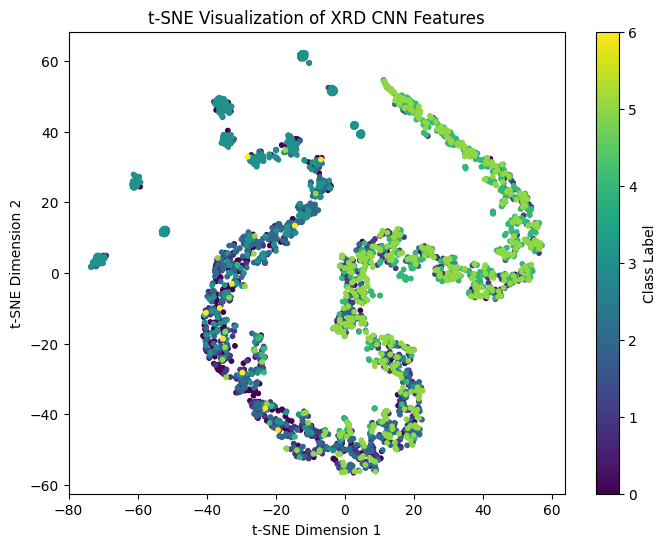

In [27]:
features, labels = extract_features_from_model(model, test_loader, device)
apply_tsne_and_visualize(features, labels)

In [28]:
def plot_certainty_histogram(model, dataloader, device):
    model.eval()  # 設定模型為推論模式
    correct_certainties = []
    incorrect_certainties = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)  # 調整輸入形狀為 [batch, 1, seq_len]

            outputs = model(inputs)

            # 計算 softmax 確定性
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)  # 取最大概率值和對應預測標籤

            # 將確定性分到正確和錯誤兩類
            correct_mask = predictions == labels
            incorrect_mask = ~correct_mask

            correct_certainties.extend(max_probs[correct_mask].cpu().numpy())  # 移動到 CPU 並轉為 NumPy 陣列
            incorrect_certainties.extend(max_probs[incorrect_mask].cpu().numpy())

    # 繪製正確與錯誤分類的直方圖
    plt.figure(figsize=(12, 6))

    # 正確分類
    plt.hist(correct_certainties, bins=20, color='green', alpha=0.7, label='Correct')
    # 錯誤分類
    plt.hist(incorrect_certainties, bins=20, color='red', alpha=0.7, label='Incorrect')

    plt.title('Network Certainty Histogram: Correct vs Incorrect')
    plt.xlabel('Certainty (Max Softmax Probability)')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


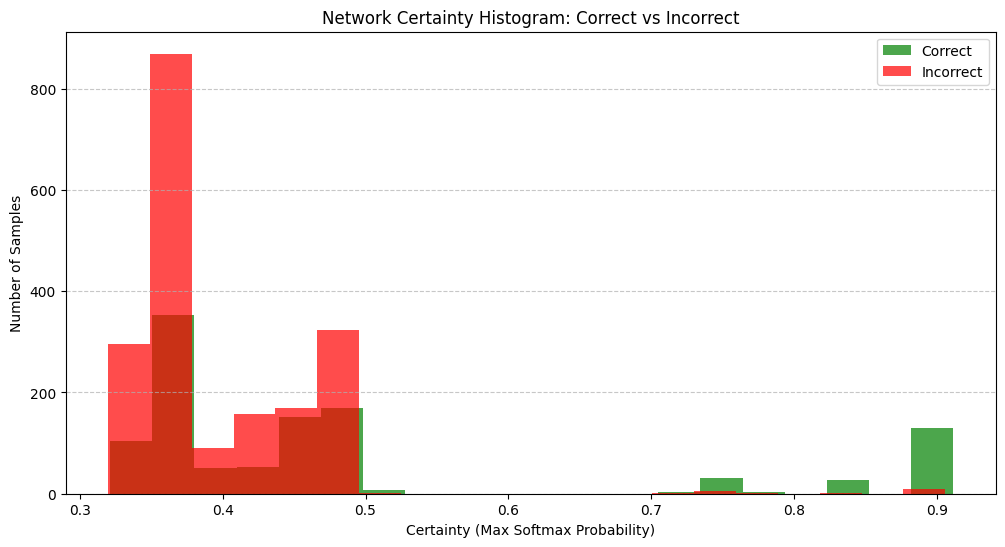

In [29]:
plot_certainty_histogram(model, test_loader, device)

In [30]:
def plot_peak_position_correlation(features, certainties, max_peaks=10):
    # 確保 features 大小正確 (假設前 max_peaks 是波峰位置)
    peak_positions = features[:, :max_peaks]  # 提取波峰位置部分

    # 計算波峰位置與模型信心的相關性
    correlation = []
    for i in range(max_peaks):
        correlation.append(np.corrcoef(peak_positions[:, i], certainties)[0, 1])

    # 繪製 heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(correlation).reshape(1, -1), annot=True, fmt=".2f", cmap="viridis",
                xticklabels=[f"Peak {i+1}" for i in range(max_peaks)], yticklabels=["Certainty"])
    plt.title("Peak Position Correlation with Certainty")
    plt.xlabel("Peak Index")
    plt.ylabel("Correlation")
    plt.show()


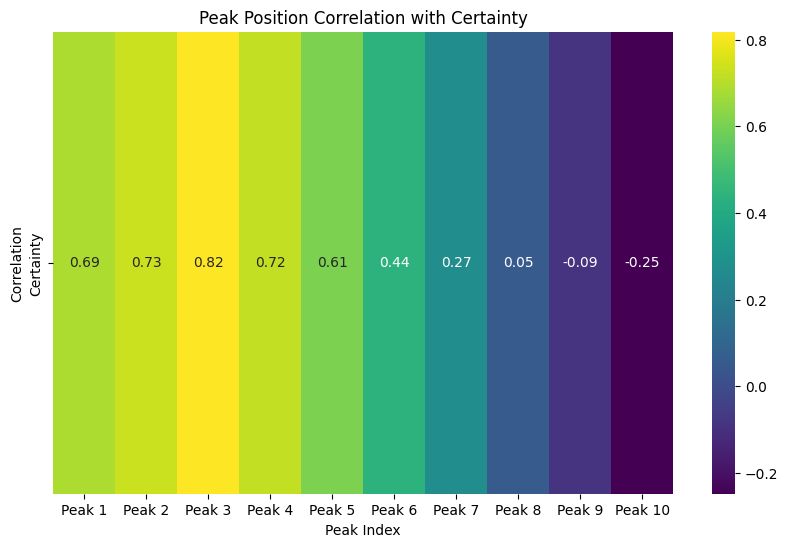

In [31]:
# 確保 features_from_peak 和 certainties 一致
features_from_peak = X_test[:, :max_peaks]
certainties = []

# Certainty 計算
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.reshape(inputs.shape[0], 1, -1)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probabilities, dim=1)
        certainties.extend(max_probs.cpu().numpy())

# 確保長度匹配
assert features_from_peak.shape[0] == len(certainties), "Mismatch between features and certainties!"

# 繪製相關性圖
plot_peak_position_correlation(features_from_peak, certainties, max_peaks=10)


#sCNN_BiLSTM

In [32]:
import torch
import torch.nn as nn

class Simplified_CNN_BiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(Simplified_CNN_BiLSTM, self).__init__()
        # CNN 部分
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)  # 輸入通道數 2
        self.pool = nn.MaxPool1d(kernel_size=2)  # 長度減半
        self.dropout = nn.Dropout(0.5)

        # LSTM 部分
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=True)

        # 全連接層
        self.fc = nn.Linear(32 * 2, num_classes)  # BiLSTM 輸出雙向拼接

    def forward(self, x):
        # CNN
        x = torch.relu(self.conv1(x))  # [batch_size, 32, 4250]
        x = self.pool(x)  # [batch_size, 32, 2125]
        x = self.dropout(x)

        # LSTM
        x = x.permute(0, 2, 1)  # [batch_size, 32, 2125] -> [batch_size, 2125, 32]
        x, _ = self.lstm(x)  # [batch_size, 2125, 64]
        x = x[:, -1, :]  # 取最後一個時間步的輸出 [batch_size, 64]

        # 全連接層
        x = self.fc(x)  # [batch_size, num_classes]
        return x


##Training

**Note: pick loss function here.**

In [33]:
# 定義類別數量（如晶系數量）
num_classes = 7

# 初始化模型
sim_model = Simplified_CNN_BiLSTM(num_classes=num_classes).to(device)
print(sim_model)

# 定義損失函數與優化器
# Pick loss function here
# criterion = FocalLoss(gamma=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sim_model.parameters(), lr=0.001)
loss_list = []
val_acc_list = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# 訓練範例
def sim_train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)  # 調整輸入形狀為 [batch, 1, seq_len]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss_list.append(running_loss)
        val_loss,val_acc = evaluate_epoch(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Acc on Val: {val_acc:.4f}")


Simplified_CNN_BiLSTM(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(32, 32, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=64, out_features=7, bias=True)
)


In [34]:
epochs = 1
# 開始訓練
sim_train_model(sim_model, train_loader, criterion, optimizer, num_epochs=epochs)

Epoch 1/1, Loss: 1.6787
Epoch 1/1, Acc on Val: 0.4279


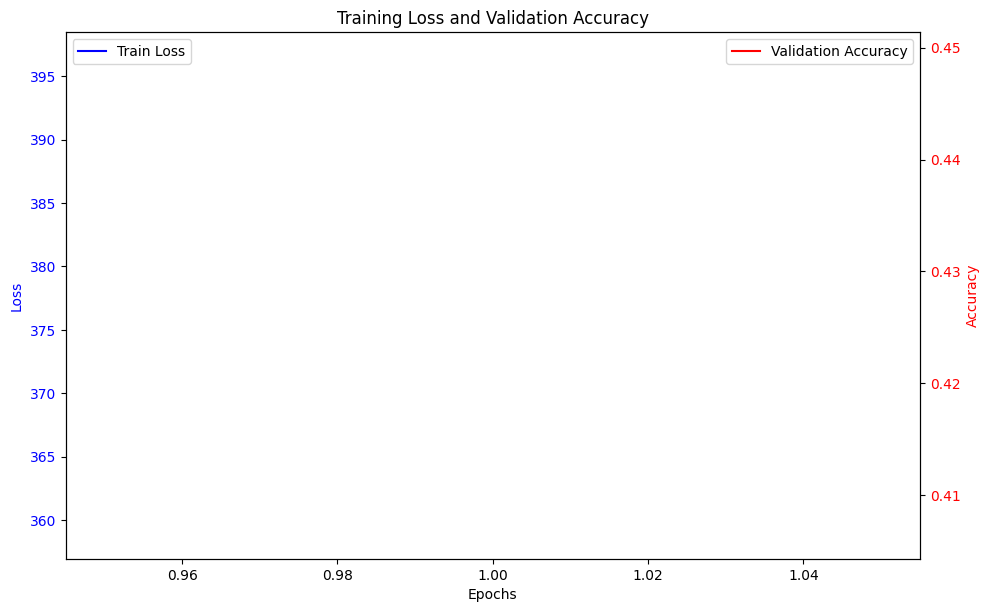

In [35]:
plot_loss_and_accuracy(loss_list, val_acc_list, epochs)

##Evaluation

In [36]:
evaluate_model(sim_model, test_loader)

Accuracy: 38.44%


38.438538205980066

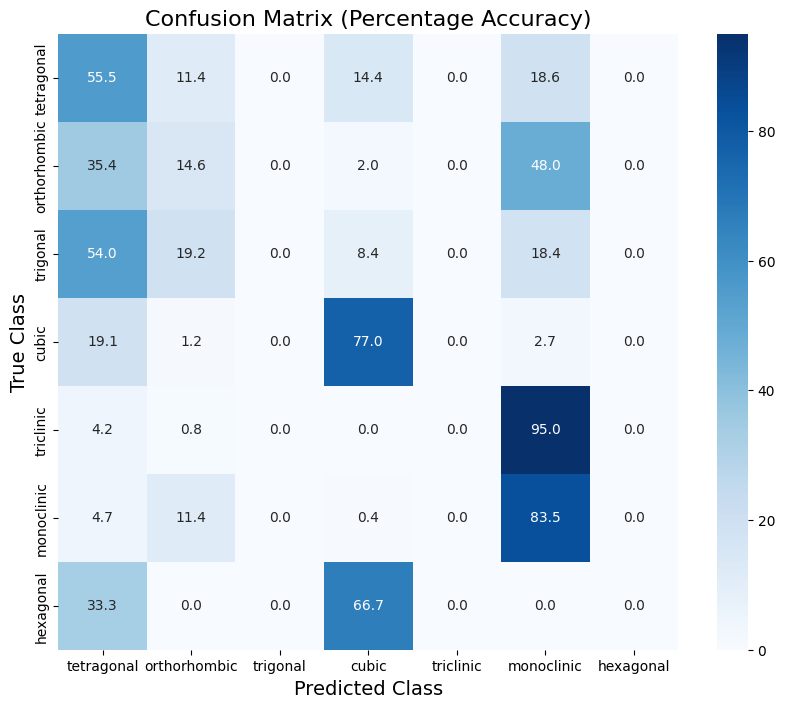

In [38]:
confusion_matrix_percent = evaluate_and_plot_confusion_matrix(sim_model, test_loader, label_map)

In [39]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE

def extract_features_from_model(model, dataloader, device):
    model.eval()  # 設定為推論模式
    all_features = []
    all_labels = []

    with torch.no_grad():  # 停止梯度計算
        for inputs, labels in dataloader:
            # 確保數據與設備匹配
            inputs = inputs.reshape(inputs.shape[0], 1, -1)
            inputs, labels = inputs.to(device), labels.to(device)

            # 特徵提取過程
            x = torch.relu(model.conv1(inputs))  # 第一層卷積
            x = model.pool(x)
            # x = torch.relu(model.conv2(x))
            # x = model.pool(x)
            x = model.dropout(x)  # 卷積模塊的輸出

            # 如果需要提取 LSTM 特徵
            x = x.permute(0, 2, 1)  # 調整維度給 LSTM
            x, _ = model.lstm(x)  # BiLSTM 層輸出
            features = x[:, -1, :]  # 取最後一個時間步的輸出

            all_features.append(features.cpu().numpy())  # 將特徵移至 CPU 並轉為 numpy 格式
            all_labels.append(labels.cpu().numpy())  # 將標籤移至 CPU 並轉為 numpy 格式

    # 將所有 batch 特徵與標籤拼接
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_features, all_labels


def apply_tsne_and_visualize(features, labels):
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Encode labels to numerical values for coloring
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    # Plot the t-SNE visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=encoded_labels, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Class Label')
    plt.title('t-SNE Visualization of XRD CNN Features')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()

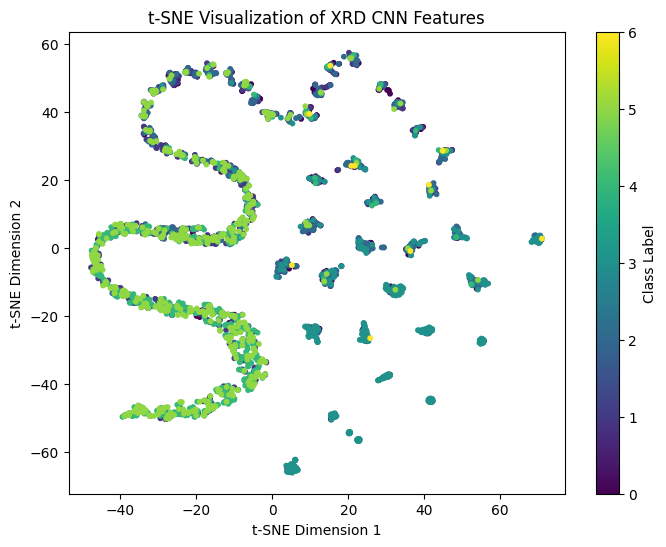

In [40]:
features, labels = extract_features_from_model(sim_model, test_loader, device)
apply_tsne_and_visualize(features, labels)

In [41]:
def plot_certainty_histogram(model, dataloader, device):
    model.eval()  # 設定模型為推論模式
    correct_certainties = []
    incorrect_certainties = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.reshape(inputs.shape[0], 1, -1)  # 調整輸入形狀為 [batch, 1, seq_len]

            outputs = model(inputs)

            # 計算 softmax 確定性
            probabilities = torch.softmax(outputs, dim=1)
            max_probs, predictions = torch.max(probabilities, dim=1)  # 取最大概率值和對應預測標籤

            # 將確定性分到正確和錯誤兩類
            correct_mask = predictions == labels
            incorrect_mask = ~correct_mask

            correct_certainties.extend(max_probs[correct_mask].cpu().numpy())  # 移動到 CPU 並轉為 NumPy 陣列
            incorrect_certainties.extend(max_probs[incorrect_mask].cpu().numpy())

    # 繪製正確與錯誤分類的直方圖
    plt.figure(figsize=(12, 6))

    # 正確分類
    plt.hist(correct_certainties, bins=20, color='green', alpha=0.7, label='Correct')
    # 錯誤分類
    plt.hist(incorrect_certainties, bins=20, color='red', alpha=0.7, label='Incorrect')

    plt.title('Network Certainty Histogram: Correct vs Incorrect')
    plt.xlabel('Certainty (Max Softmax Probability)')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


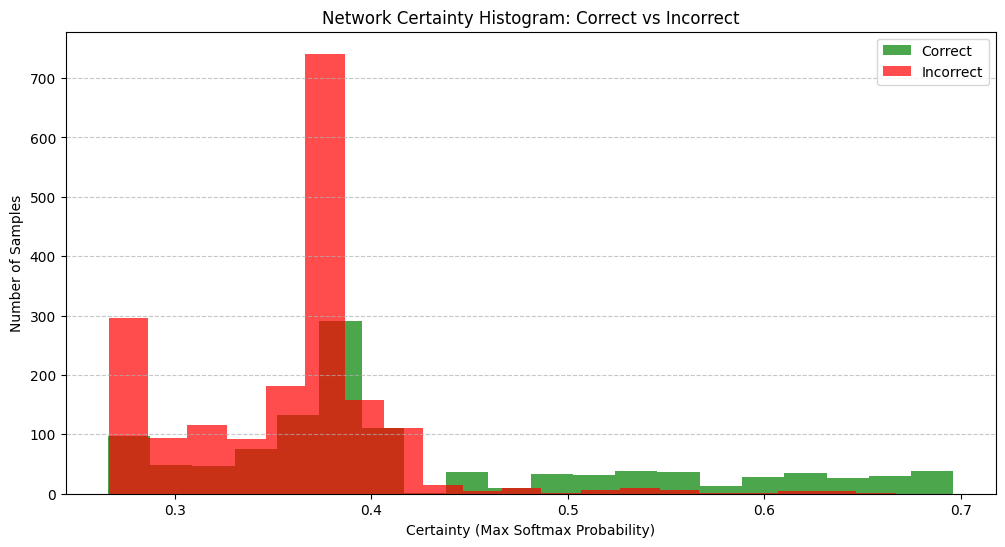

In [42]:
plot_certainty_histogram(sim_model, test_loader, device)

In [43]:
def plot_peak_position_correlation(features, certainties, max_peaks=10):
    # 確保 features 大小正確 (假設前 max_peaks 是波峰位置)
    peak_positions = features[:, :max_peaks]  # 提取波峰位置部分

    # 計算波峰位置與模型信心的相關性
    correlation = []
    for i in range(max_peaks):
        correlation.append(np.corrcoef(peak_positions[:, i], certainties)[0, 1])

    # 繪製 heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(correlation).reshape(1, -1), annot=True, fmt=".2f", cmap="viridis",
                xticklabels=[f"Peak {i+1}" for i in range(max_peaks)], yticklabels=["Certainty"])
    plt.title("Peak Position Correlation with Certainty")
    plt.xlabel("Peak Index")
    plt.ylabel("Correlation")
    plt.show()


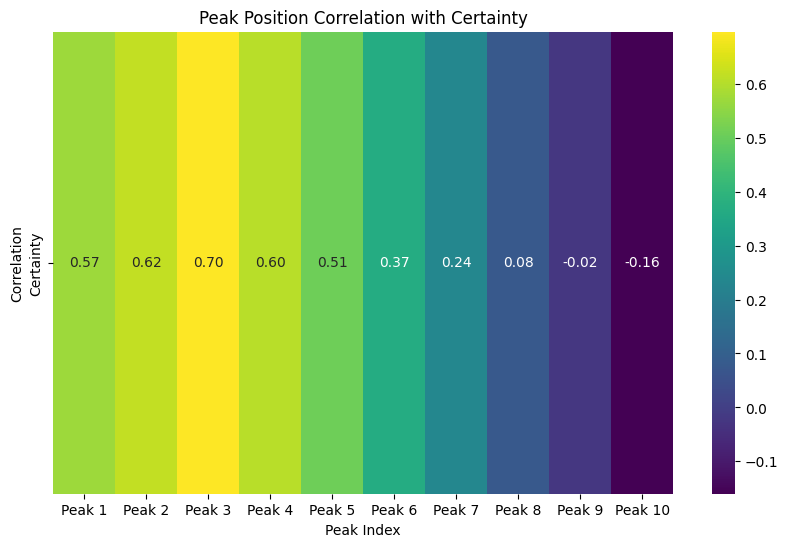

In [44]:
# 確保 features_from_peak 和 certainties 一致
features_from_peak = X_test[:, :max_peaks]
certainties = []

# Certainty 計算
sim_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.reshape(inputs.shape[0], 1, -1)
        outputs = sim_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probabilities, dim=1)
        certainties.extend(max_probs.cpu().numpy())

# 確保長度匹配
assert features_from_peak.shape[0] == len(certainties), "Mismatch between features and certainties!"

# 繪製相關性圖
plot_peak_position_correlation(features_from_peak, certainties, max_peaks=10)
